
Informe

Integrantes: Ignacio Cordova, Andres Rumillanca


Descripción del problema

Existen ciertas complicaciones al trabajar con datos del repositorio LAMBDA de la NASA, tales problemas surgen debido al tamaño y la desorganización de los archivos dentro de dicho repositorio.

Los datos presentes están en distintos formatos y tamaños lo cual dificulta su análisis y manipulación directos, es debido a esto que decidimos estudiar y tratar de facilitar el trabajo de dichos datos mediante una base de datos NoSQL, más específicamente MongoDB.

El presente trabajo abordará dicha problemática la complejidad del manejo de los datos del repositorio LAMBDA, más específicamente nos centraremos en los datos de la misión WMAP la cual estudió el fondo de radiación de microondas.

Desarrollo 

Para afrontar esta problemática se comenzó con un enfoque en el manejo de los datos más que en la base de datos en sí. Esto quiere decir que se decidió por hacer una especie de “esqueleto del programa” el cual no contaría inmediatamente con la implementación con mongoDB.

Se hizo de esta forma para poder facilitar el trabajo de programación. El proyecto en sí se dividió en 2 partes, la primera que implementa la manipulación de los datos y las consultas y la segunda que sería la implementación con mongoDB.

Primera parte

Lo primero que se hizo en esta parte del proyecto fue crear una bases de datos “simulada”(osea simplemente cargar los datos al ambiente de jupyter al estilo de mongoDB pero sin haberlo implementado aún), dicha base de datos contiene cosas como categorías, descripciones de estas y datos dentro de ellas(o productos).

Algunas de las consultas que se implementaron durante esta etapa fueron: Visualización de las categorías y sus productos, búsqueda de una categoría en específico, búsqueda de un producto específico, añadir un producto a una categoría, actualizar la descripción de una categoría, entre otras.

Tras la implementación de las consultas antes mencionadas se procedió a la creación de los gráficos, a partir de los datos usados se pudo generar 2 gráficos.

El primero es un gráfico de la temperatura del CMB en formato mollweide, este gráfico nos ayuda a ver la temperatura del CMB en distintas secciones del espacio, para así poder observar qué secciones son más calientes y cuales son más frías.

El segundo es un gráfico de la polarización de la luz en el CMB también en formato mollweide, este gráfico nos ayuda a ver que tan polarizada estaba la luz en esta época cosmológica. El estudio de este fenómeno es muy importante ya que nos ayuda a dar luces sobre fenómenos tales como la inflación del universo o el big bang.

En esta etapa se utilizaron las siguientes librerías: healpy para el correcto procesamiento de los datos de la base de datos, astropy para poder utilizar el formato fits, matplotlib para poder generar los gráficos y numpy para poder hacer ciertas operaciones matemáticas necesarias para el correcto manejo de los datos.


Segunda Parte

La segunda parte del proyecto constó principalmente en la implementación de mongoDB al proyecto, esto se hizo mediante la librería pymongo.

En esta parte del proyecto debimos dejar de utilizar la librería healpy debido a problemas con nuestros sistemas, para afrontar esta problemática decidimos trabajar las imágenes con astropy netamente.Lamentablemente esto llevó a una pérdida en la calidad de los gráficos, pero no así en su funcionalidad la cual resulta ser la misma.

Decidimos además trabajar con la intensidad lumínica lo cual naturalmente alteró el cómo se ven los gráficos, esta variable también es importante en un sentido astrofísico, ya que nos permite ver cómo fluctúa la densidad de la materia en el universo temprano, cosa extremadamente importante en el cálculo de las ecuaciones de estado del universo temprano y en el estudio de la constante cosmológica.

Conclusiones


A causa de todo lo planteado y el código creado se puede concluir que la implementación con mongoDB facilita mucho el análisis de esta base de datos debido a múltiples factores, entre los cuales podemos destacar: 


Facilidad de trabajo con API’s astrofísicas
Posibilidad de trabajar en un servidor, lo cual nos permite manipular los datos al mismo tiempo en distintos equipos
Permite un esquema dinámico, lo cual en este caso es necesario debido a la gran diversidad de los datos.
Sumado a esto nos permite graficar los datos con gran eficiencia lo cual es muy útil para bases de datos como la de LAMBDA debido a que para tener un estudio rígido y conciso de dichos datos es necesario graficarlos para así poder ajustar los modelos cosmológicos actuales. 


In [1]:
import pymongo
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
from scipy.interpolate import griddata

In [37]:
# Conexión a MongoDB
def setup_database():
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    db = client["wmap_database"]
    return db

# Guardar datos de imagen en fragmentos pequeños
def split_and_insert_image_data(db, image_data, hdu_index):
    collection = db["image_data"]
    chunk_size = 1000  # Filas por fragmento (ajusta según sea necesario)
    
    for i in range(0, len(image_data), chunk_size):
        chunk = image_data[i:i + chunk_size]
        document = {
            "type": "ImageHDU",
            "hdu_index": hdu_index,
            "chunk_index": i // chunk_size,
            "data": chunk.tolist()
        }
        collection.insert_one(document)

# Guardar matrices grandes como archivos externos y registrar referencias en MongoDB
def save_large_data_to_file(db, image_data, file_name, hdu_index):
    os.makedirs("output", exist_ok=True)
    file_path = f"output/{file_name}_hdu_{hdu_index}.npy"
    np.save(file_path, image_data)  # Guardar como archivo .npy
    
    # Registrar referencia en MongoDB
    db["image_references"].insert_one({
        "type": "ImageHDU",
        "hdu_index": hdu_index,
        "file_path": file_path
    })

# Procesar y almacenar tablas en MongoDB
def process_table_data(db, table_data, hdu_index):
    collection = db["table_data"]
    column_names = table_data.columns.names
    
    for row in table_data:
        document = {
            key: row[key].item() if isinstance(row[key], np.generic) else row[key]
            for key in column_names
        }
        document["hdu_index"] = hdu_index
        collection.insert_one(document)

# Procesar archivo FITS
def process_fits_file(db, fits_file):
    with fits.open(fits_file) as hdul:
        print(f"Procesando archivo: {fits_file}")
        hdul.info()
        
        for i, hdu in enumerate(hdul):
            if isinstance(hdu, fits.ImageHDU):
                print(f"Procesando ImageHDU en extensión {i}")
                image_data = hdu.data
                if image_data is not None:
                    if image_data.nbytes > 16 * 1024 * 1024:  # Si supera 16 MB
                        save_large_data_to_file(db, image_data, "image_data", i)
                    else:
                        split_and_insert_image_data(db, image_data, i)
            elif isinstance(hdu, fits.BinTableHDU):
                print(f"Procesando BinTableHDU en extensión {i}")
                process_table_data(db, hdu.data, i)


In [57]:
# Main function
if __name__ == "__main__":
    # Configuración de la base de datos
    db = setup_database()
    
    # Archivos FITS de ejemplo
    fits_files = ["wmap_mollweide_band_imap_r9_9yr_K_v5.fits"] 
    
    # Procesar archivos FITS
    for file in fits_files:
        process_fits_file(db, file)

Procesando archivo: wmap_mollweide_band_imap_r9_9yr_K_v5.fits
Filename: wmap_mollweide_band_imap_r9_9yr_K_v5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      22   ()      
  1  TEMPERATURE    1 ImageHDU        22   (4096, 2048)   float32   
  2  N_OBS         1 ImageHDU        22   (4096, 2048)   float32   
Procesando ImageHDU en extensión 1
Procesando ImageHDU en extensión 2


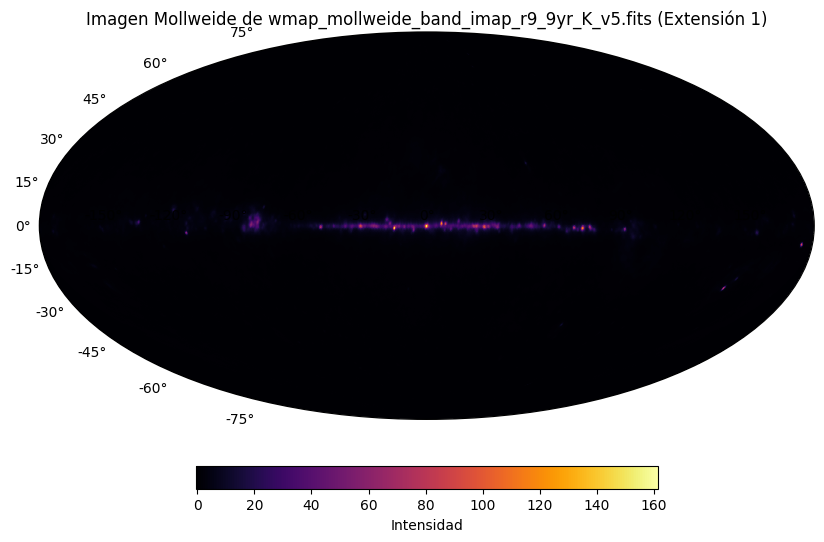

In [53]:
# Función para graficar un archivo FITS
def plot_fits_image(fits_file, extension=1):
    try:
        # Abrir el archivo FITS
        with fits.open(fits_file) as hdul:
            # Leer los datos de la extensión especificada
            image_data = hdul[extension].data
            
            if image_data is None:
                raise ValueError(f"La extensión {extension} no contiene datos de imagen.")
            
            # Crear un mapa de coordenadas
            n_lat, n_lon = image_data.shape
            lon = np.linspace(-np.pi, np.pi, n_lon)
            lat = np.linspace(-np.pi / 2, np.pi / 2, n_lat)
            lon_grid, lat_grid = np.meshgrid(lon, lat)
            
            # Graficar los datos usando la proyección Mollweide
            plt.figure(figsize=(10, 6))
            ax = plt.subplot(111, projection="mollweide")
            im = ax.pcolormesh(lon_grid, lat_grid, image_data, cmap="inferno", shading="auto")
            
            # Añadir barra de color
            cbar = plt.colorbar(im, ax=ax, orientation="horizontal", fraction=0.05, pad=0.1)
            cbar.set_label("Intensidad")
            
            # Configurar título
            plt.title(f"Imagen Mollweide de {fits_file} (Extensión {extension})")
            plt.show()

    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {fits_file}.")
    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Se produjo un error inesperado: {e}")

# Archivo FITS de ejemplo
fits_file = "wmap_mollweide_band_imap_r9_9yr_K_v5.fits"

# Llamar a la función para graficar
plot_fits_image(fits_file, extension=1)  # Cambia la extensión si es necesario


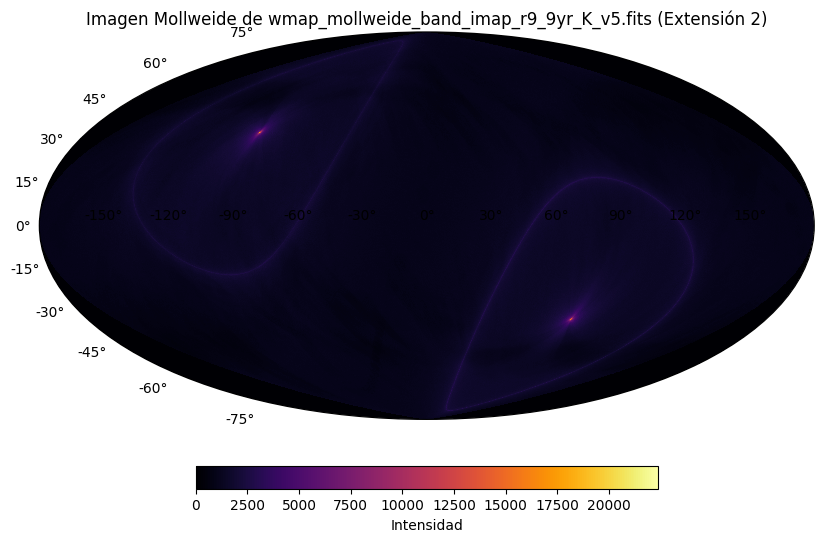

In [54]:
# Función para graficar un archivo FITS
def plot_fits_image(fits_file, extension=2):
    try:
        # Abrir el archivo FITS
        with fits.open(fits_file) as hdul:
        # Leer los datos de la extensión especificada
            image_data = hdul[extension].data
           
            
            if image_data is None:
                raise ValueError(f"La extensión {extension} no contiene datos de imagen.")
            
            # Crear un mapa de coordenadas
            n_lat, n_lon = image_data.shape
            lon = np.linspace(-np.pi, np.pi, n_lon)
            lat = np.linspace(-np.pi / 2, np.pi / 2, n_lat)
            lon_grid, lat_grid = np.meshgrid(lon, lat)
            
            # Graficar los datos usando la proyección Mollweide
            plt.figure(figsize=(10, 6))
            ax = plt.subplot(111, projection="mollweide")
            im = ax.pcolormesh(lon_grid, lat_grid, image_data, cmap="inferno", shading="auto")
            
            # Añadir barra de color
            cbar = plt.colorbar(im, ax=ax, orientation="horizontal", fraction=0.05, pad=0.1)
            cbar.set_label("Intensidad")
            
            # Configurar título
            plt.title(f"Imagen Mollweide de {fits_file} (Extensión {extension})")
            plt.show()

    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {fits_file}.")
    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Se produjo un error inesperado: {e}")

# Archivo FITS de ejemplo
fits_file = "wmap_mollweide_band_imap_r9_9yr_K_v5.fits"

# Llamar a la función para graficar
plot_fits_image(fits_file, extension=2)  # Cambia la extensión si es necesario


In [108]:
def find_data(file, extension=2):
    # Abrir el archivo FITS
    with fits.open(fits_file) as hdul:
        # Leer los datos de la extensión especificada
        image_data = hdul[extension].data
    
        # Define el rango de coordenadas
        coord_min = SkyCoord(ra=10, dec=20, unit="deg")
        coord_max = SkyCoord(ra=30, dec=40, unit="deg")
    
        # Filtrar datos dentro del rango de coordenadas
        ra_values = np.linspace(-np.pi, np.pi, image_data.shape[1])
        dec_values = np.linspace(-np.pi / 2, np.pi / 2, image_data.shape[0])
        ra_grid, dec_grid = np.meshgrid(ra_values, dec_values)
    
        coords = SkyCoord(ra=ra_grid, dec=dec_grid, unit="rad")
        mask = (coords.ra >= coord_min.ra) & (coords.ra <= coord_max.ra) & \
                   (coords.dec >= coord_min.dec) & (coords.dec <= coord_max.dec)
    
        filtered_data = image_data[mask]
    
        # Imprimir la forma de los datos filtrados (ejemplo)
        print(("en las coordenadas elegidas hay un promedio de",filtered_data.shape,"datos"))

def calculate_statistics(file, extension=2):
    with fits.open(fits_file) as hdul:
        # Leer los datos de la extensión especificada
        image_data = hdul[extension].data
        # Define una máscara circular para la región de interés
        center_x, center_y = 500, 300
        radius = 100
        mask = np.sqrt((np.arange(image_data.shape[1]) - center_x)**2 + \
                      (np.arange(image_data.shape[0])[:, np.newaxis] - center_y)**2) <= radius
        
        # Calcula la media de los datos dentro de la región de interés
        mean_value = np.mean(image_data[mask])
        
        # Imprimir la media (ejemplo)
        print ("el valor promedio de la intensidad en la region seleccionada es:",mean_value) 

def data_table(file, db, extension=2):
    with fits.open(file) as hdul:
        # Leer los datos de la extensión especificada
        image_data = hdul[extension].data
        
        # Convertir los datos de la imagen a DataFrame
        image_data = pd.DataFrame(image_data)
        image_data["hdu_index"] = extension  # Añadir hdu_index si no está presente

        # Obtener datos de tabla desde MongoDB
        table_docs = list(db["table_data"].find())
        if not table_docs:
            print("No se encontraron datos en la colección table_data.")
            return

        table_df = pd.DataFrame(table_docs)
        if "hdu_index" not in table_df.columns:
            print("La columna 'hdu_index' no existe en table_data.")
            return

        # Realizar la combinación
        merged_data = pd.merge(table_df, image_data, on="hdu_index", how='inner')

        # Imprimir las primeras filas del DataFrame combinado (ejemplo)
        print(merged_data.head())


In [109]:
# Main function
if __name__ == "__main__":
    # Configuración de la base de datos
    db = setup_database()
    
    # Archivos FITS de ejemplo
    fits_files = ["wmap_mollweide_band_imap_r9_9yr_K_v5.fits"] 

    find_data(fits_file, extension=2)

    calculate_statistics(fits_file, extension=2)

    data_table(fits_file, db, extension=2)

('en las coordenadas elegidas hay un promedio de', (51756,), 'datos')
el valor promedio de la intensidad en la region seleccionada es: 196.78464
No se encontraron datos en la colección table_data.
